_editors : Maïlys Blanc, Virgile Bessot, Timothé Antonini, Camille Bellemin_
# Thermal circuit and state-space representation for a thermal circuit with capacities in some nodes :  building 

This report presents the theory of heat transfer in buildings and examplifies it on a chosen building.

*Objectives:*
- Analyse a chosen building with 2 rooms, 4 identical walls and a partition between the rooms (2 glass windows and a pvc door), air infiltration, and HVAC system controlling the indoor air temperature.
- Model the heat transfer in the building by a thermal circuit.
- Obtain the mathematical model as a system of Differential Algebraic Equations (DAE) from the thermal circuit.
- Transfrom the system of DAE into state-space representation.
- Find the steady-state solution.
- Simulate by using Euler methods for numerical integration..

# Boundary conditions

    For our first model, we have chosen the following conditions to simplify as much as possible :
        - The buildings exchanges with the outdoor, the outdoor temperature is homogenous
        - The radiations of the sun are diffuse, we have the same flux everywhere on the walls
        - We consider that the heat exchanges with the ground are negligible, we suppose that the floor is perfectly insulated
        - We consider that the roof top has the same thermical properties as the walls
        - We consider that the indoor temperature is homogenous
        - We neglect long wave radiation
        
    The final flux that we have for this model are : 
        - Sun's radiaitons that are homogenous all around the building, including the roof 
        - Conductive and convective exchanges with the outdoor

In [2752]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

Here is our house : 
![cube](.//Building_plan_group7.png)

The wall is composed of two materials: concrete and insulation. The wall 1 in normally insolated and wall 2 is supposed to be perfectly insolated. The windows are simple glazed glass windows.  The door is in PVC. The thermal properties of the materials of the wall are:

Let's consider the surface area of the walls 6 x 3 m² & 10 x 3 m² and the volume of the indoor air is 6 x 10 x 3 m³.

In [2753]:
V_air = 6 * 10 * 3   # m³, indoor air volume

In [2754]:
air = {'Density': 1.2,                      # kg/m³
       'Specific heat': 1000}               # J/(kg·K)
# pd.DataFrame.from_dict(air, orient='index', columns=['air'])
pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


In [2755]:
concrete = {'Conductivity': 1.400,
            'Density': 2300.0,
            'Specific heat': 880,
            'Width': 0.2,
            'Surface': 5*3-1*3+10*3-1.2*3+5*3-1*3+10*3}

insulation = {'Conductivity': 0.040,
              'Density': 16.0,
              'Specific heat': 1210,
              'Width': 0.1,
              'Surface': 5*3-1*3+10*3-1.2*3+5*3-1*3+10*3}



glass = {'Conductivity': 1.4,
         'Density': 2500,
         'Specific heat': 1210,
         'Width': 0.04,
         'Surface': 2*3}
         
pvc = {'Conductivity': 0.2,
         'Density': 1.4,
         'Specific heat': 840,
         'Width': 0.05,
         'Surface': 1.2*3}
         

wall = pd.DataFrame.from_dict({'Layer_out': insulation,
                               'Layer_in': concrete,
                               'Glass': glass,
                               'Pvc': pvc },
                              orient='index')
wall

,Conductivity,Density,Specific heat,Width,Surface
Layer_out,0.04,16.0,1210,0.10,80.4
Layer_in,1.40,2300.0,880,0.20,80.4
Glass,1.40,2500.0,1210,0.04,6.0
Pvc,0.20,1.4,840,0.05,3.6


In [2756]:
air = {'Density': 1.2,
       'Specific heat': 1000}

pd.DataFrame(air, index=['Air'])

,Density,Specific heat
Air,1.2,1000


In [2757]:
# convection coefficients, W/(m²·K)
h = pd.DataFrame([{'in': 8., 'out': 10.}], index=['h'])
h

,in,out
h,8.0,10.0


# Let us start to draw the thermal circuit
## Thermal circuit

Heat transfert is:
- through the walls (concrete and insulation), 
- through the double glazed glass windows,

The HVAC system is modelled as a proportional controller. There is long wave radiative exchange between the wall and the glass window. The sources are:
- temperature sources:
    - outdoor atmospheric air;
    - indoor air temperature setpoint;
- flow rate sources:
    - solar radiation on the outdoor and the indoor walls;
    - auxiliary heat gains in the thermal zone.

![cube](.//Thermal_circuit_group_7.png)

### Let us consider the thermal conductances for conduction, convection, long-wave radiation, and advection.

#### Thermal conductance
$$G_{cd} = \frac{\lambda}{w}S$$


In [2758]:
# conduction
G_cd = wall['Conductivity'] / wall['Width'] * wall['Surface']
pd.DataFrame(G_cd, columns={'Conductance'})

,Conductance
Layer_out,32.16
Layer_in,562.80
Glass,210.00
Pvc,14.40


#### Convection
For the inside convection coefficient, we add 4 (by convention) in order to consider easily the radiating factor. 

In [2759]:
# convection
Gw = h * wall['Surface'][0]     # wall
Gg = h * wall['Surface'][2]     # glass
Gd= h*wall['Surface'][3]        # door glass


#### Advection

In [2760]:
# ventilation flow rate
Va = V_air                  # m³, volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration
# ventilation & advection
Gv = air['Density'] * air['Specific heat'] * Va_dot


> Table 1. Typical values for the ventilation rates (in air changes per hour, ACH) as a function of the position of windows (H. Recknagel, E. Spenger, E_R Schramek (2013), Table 1.12.1-4)

| Position of windows                     | Ventilation rate, ACH [h⁻ⁱ] |
| --------------------------------------- | ---------------------- |
| Window closed, doors closed             | 0 to 0.5 |
| Tilted window, venetian blind closed    | 0.3 to 1.5 |
| Tilted window, whitout venetian blind   | 0.8 to 4.0 |
| Window half opened                      | 5 to 10 |
| Window fully open                       | 9 to 15 |
| Window and French window fully open (cross ventilation) | about 40 |


In [2761]:
# glass: convection outdoor & conduction
Ggs = float(1 / (1 / Gg['out'] + 1 / (2 * G_cd['Glass'])))

#### Resistances

We have

$$R_{cd} = \frac{w}{\lambda S}$$

where:

- $w$ is the [width](https://en.m.wikipedia.org/wiki/Length) of the material, m;
- $\lambda$ - [thermal conductvity](https://en.m.wikipedia.org/wiki/Thermal_conductivity) of the material, W/(m·K);
- $S$ - [surface area](https://en.m.wikipedia.org/wiki/Surface_area) of the wall, m².

In [2762]:
he=h["out"] #h ext
hi=h["in"] #h interieur
Sint2=5.4*5.6 #surface au sol piece 2
Sm1=3*5*3-1*3-1.2*3 #surface mur 1
Sm12=4.4*3 #surface mur mileu
Sp=1.2*3 # surface portes
Sf=1*3 #surface fenetres
eb=0.2 #epaisseur beton
ei=0.1 #epaisseur isolant
ef=0.01 #epaisseur fenetre
ep=0.05 # epaisseur porte
em12=0.1 #epaisseur mur mileu
lda_b =1.4 #conductivité thermique du beton
lda_i = 0.04#conductivité du beton
lda_p = 0.2#conductivité pvc
lda_f = 1.4#conductivité vitre
dens_b = 2300#densité beton
dens_i = 16#densité isolant
dens_f = 2500#densité fenêtre
dens_p = 1410#densité porte
dens_air=1.2 #densite air
cb=880 #capacité thermique beton
ci=1210
cf=1210
cp=840
cair=1000
Vair = 1**3 #volume d'air ventilation (m3)
ACH = 1 #air changes per hour
Va_dot = ACH/3600 * Vair #débit d'air dans la ventilation (m3/s)
Kp=1e9

R0=1/(he*Sm1) 
R1=R2=eb/(2*lda_b*Sm1) #accumulation de chaleur beton
R3=R4=ei/(2*lda_i*Sm1) #accumulation de chaleur isolant
R5=(1/(he*Sf))+(ef/(2*lda_f*Sf)) #convection fenetre -ext + moitié conduction
R6=1/(he*Sp) #convectiopn ext-porte
R7=R8=ep/(2*lda_p*Sp) #accumulation
R9=1/(hi*Sm1) #convection mur -int
R10=(1/(hi*Sf))+(ef/(2*lda_f*Sf)) #convection fenetre-int + moitié conduction
R11=1/(hi*Sp) #convection porte int
R13=1/Kp
R12= 1/(Va_dot*dens_air*cair)
R14=1/(hi*Sp) #convection interieur porte
R15=1/(hi*Sm12) 
R16=R17=em12/(2*lda_p*Sp)
R18=1/(hi*Sp)
R19=R20=em12/(2*lda_b*Sm12)
R21=1/(hi*Sm12)
R23=1/Kp
R22=1/(Va_dot*dens_air*cair)
R24=(1/(he*Sf))+(ef/(2*lda_f*Sf))
R25=(1/(hi*Sf))+(ef/(2*lda_f*Sf))

#### Thermal Capacities
The [thermal capacities](https://en.m.wikipedia.org/wiki/Heat_capacity) of the wall are of the form:

$$C_w= m_w c_w= \rho_w c_w w_w S_w$$

where:
- $m_w = \rho_w w_w S_w$ is the [mass](https://en.m.wikipedia.org/wiki/Mass) of the material of the wall, kg;
- $c_w$ - [specific heat capacity](https://en.m.wikipedia.org/wiki/Specific_heat_capacity) of the material, J/(kg⋅K);
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density) of the material, kg/m³;
- $w_w$ - width of the wall, m;
- $S_w$ - surface area of the wall, m²

In [2763]:
C = wall['Density'] * wall['Specific heat'] * wall['Surface'] * wall['Width']

The thermal capacity of the air is:

$$C_a = m_a c_a = \rho_a c_a V_a$$

where:
- $m_a = \rho_a V_a$ is the mass of the air, kg;
- $\rho_w$ - [density](https://en.m.wikipedia.org/wiki/Density) of air, kg/m³;
- $c_a$ - specific heat capacity of the air, J/(kg⋅K);
- $V_a$ - volume of the air in the thermal zone, m³.

In [2764]:
C['Air'] = air['Density'] * air['Specific heat'] * V_air
pd.DataFrame(C, columns={'Capacity'})

,Capacity
Layer_out,155654.40
Layer_in,32545920.00
Glass,726000.00
Pvc,211.68
Air,216000.00


## Differential algebraic equations (DAE)

In [2765]:
# number of temperature nodes and flow branches
no_θ = 18 #nodes
no_q = 26 #flow

### Conductance matrix $G$

Matrix G : Number of lines and columns correspond to the number of resitances in the model. The matrix represent the conductance of the different elements (HVAC, ventilation) and surfaces (conduction and convection of walls, windows, doors...)

In [2766]:
G=np.eye(26)

G[0][0]=1/R0
G[1][1]=1/R1
G[2][2]=1/R2
G[3][3]=1/R3
G[4][4]=1/R4
G[5][5]=1/R5
G[6][6]=1/R6
G[7][7]=1/R7
G[8][8]=1/R8
G[9][9]=1/R9
G[10][10]=1/R10
G[11][11]=1/R11
G[12][12]=1/R12
G[13][13]=1/R13
G[14][14]=1/R14
G[15][15]=1/R15
G[16][16]=1/R16
G[17][17]=1/R17
G[18][18]=1/R18
G[19][19]=1/R19
G[20][20]=1/R20
G[21][21]=1/R21
G[22][22]=1/R22
G[23][23]=1/R23
G[24][24]=1/R24
G[25][25]=1/R25



### Capacity matrix $C$

Matrix C : corresponds to the capacity of walls


In [2767]:
C=np.zeros(18)

C[1] = dens_b*eb*Sm1*cb
C[3] = dens_i*ei*Sm1*ci
C[5] = dens_f*ef*Sf*cf
C[7] = dens_p*ep*Sp*cp
C[9] = dens_air*Sint2*3*cair
C[11] = dens_p*Sp*ep*cp
C[14] = dens_b*Sm12*em12*cb
C[16] = dens_air*Sint2*3*cair
C[17] = Sf*ef*cf*dens_f
C=np.diag(C)



### Arc-node incidence matrix $A$

Matrix A : Number of lines correspond to the number of flows and number of columns correspond to the number of nodes. If the path between the node and the resistance is on the same same direction as the flow, the coefficient will be 1

In [2768]:
# Arc-node incidence matrix
A = np.zeros((no_q, no_θ ))
for i in range (10):
    A[i][i]=1
A[4][3]=-1
A[9][4]=-1
A[1][0]=-1
A[2][1]=-1
A[3][2]=-1
A[7][6]=-1
A[8][7]=-1
A[11][8]=-1
A[25][17]=-1
A[24][17]=1
A[23][16]=1
A[21][16]=1
A[20][15]=1
A[19][14]=1
A[18][16]=1
A[17][12]=1
A[16][11]=1
A[15][13]=-1
A[14][10]=-1
A[22][16]=1
A[21][15]=-1
A[20][14]=-1
A[19][13]=-1
A[18][12]=-1
A[17][11]=-1
A[16][10]=-1
A[15][9]=1
A[14][9]=1
A[13][9]=1
A[11][8]=-1
A[10][5]=-1
A[9][4]=-1
A[12][9]=1
A[11][9]=1
A[10][9]=1
A[25][16]=1
pd.DataFrame(A)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### We are now defining the temperature vector $b$ and the heat flow vector $f$.
We first define the temperature vector. We have two different temperatures. The temperature of the outise $T_{out}=15°C$ and the wanted temperature $T_{HVAC}=20°C$

In [2769]:
Thvac=20
Tout=15
b=np.zeros(26)

b[0]=1
b[5]=1
b[6]=1
b[12]=1
b[13]=1
b[22]=1
b[23]=1
b[24]=1

Now, for the flux, we have two different flux. We have the flux of the sun that radiate on all the outside surfaces $\Phi_{sun_{out}}$ and the flux of the sun that radiat eon the insides surfaces $\Phi_{sun_{in}}$. Finally there are two people bringing $100W$ each in the fist room and a $40W$ lamp in each room. 
The flux in the first room is $$\dot Q_{a1}=240W$$
And the flux in the second room $$\dot Q_{a2}=40W$$




In [2770]:
Qa1 = 240
Qa2 = 40
f = np.zeros(18)

f[0] = 1
f[5] = 1
f[6] = 1
f[9] = 1
f[16] = 1

We have to define the y vector that will help us to solve the equations. It allows to have the 2 rooms' temperatures.

In [2771]:
y = np.zeros(18)         # nodes
y[[9,16]] = 1             # nodes (temperatures) of interest
print(f'y = ', y)

y =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0.]


# Steady state simulation 

We want to obtain the space representation of the model. To do that we transforme the differential-algebraic system of equations : $$C \dot{\theta} = -(A^T G A) \theta + A^T G b + f$$
in $$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_C + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$We have to comput As, Bs, Cs and Ds that represent the state coefficient. We will complete it later, when we will need it.

Now, we have to verify if the state representation and so our model isn't false. To do that, we study the steady state. At steady state the term $C \dot{\theta} = 0$. Moreover, the flow rate sources are equal to zero, outdoor temperature is 15°C and indoor temperature setpoint (temperature of the HVAC) is 20°C. We are going to execute two tests. one with the HVAC system on ($K_{p}\ne0$). And one with the HVAC off ($K_{p}=0$)

In [2772]:
f = np.zeros(18) #for steady state
b=np.zeros(26)
b[[0,5,6,24,12,22]]=Tout
b[[13,23]]=Thvac


The objective is to check if with the system of DAE we obtain approximatively the same indoor temperature as the state-space representation. 
### Test 1, HVAC system on ($K_{p}\ne0$)
- First step : value of temperature in steady state with the system of DAE by considering that $C\dot{\theta} = 0$. 
We obtain $$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

In [2773]:
Kp = 10**(25)
R13=R23=1/Kp
G[13][13]=1/R13
G[23][23]=1/R23



θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [15.1743462  15.2988792  15.4234122  17.60273973 19.78206725 17.23076923
 16.05263158 17.36842105 18.68421053 20.         20.         20.
 20.         20.         20.         20.         20.         17.23076923] °C


We obtain a vector with all the temperature of the model. Normally we must obtain an indoor temperature equal to 20°C because the HVAC si ON.

- Second step, value of temperature in steady state with state-space representation
To resolve the system we have to input the vector u. It is obtained by stacking the vectors $b_{T}$ and $f_{Q}$. $b_{T}$ and $f_{Q}$ respectively correspond to the temperature values of the model and to flow values of the model.
$b_{T}$ and $f_{Q}$ are non zero elements of vector $b$ and $f$


In [2774]:
bT=np.ones(8)
bT*=Tout
bT[4],bT[6]=Thvac,Thvac

absorption_vitre = 0.15
absorption_porte = 0.6
absorption_beton = 0.6

fQ=np.ones(5)
phi_sun = 400 #W/m2
fQ[0] = phi_sun*Sm1*absorption_beton
fQ[1] = phi_sun*Sf*absorption_vitre
fQ[2] = phi_sun*Sp*absorption_porte
fQ[3] = Qa1
fQ[4] = Qa2




As we are in steady state, the flow rate sources are taken equal to 0.

In [2775]:
fQ=np.zeros(5) #on ne considère pas les flux en régime permanant
u = np.hstack([bT])
print (u)

[15. 15. 15. 15. 20. 15. 20. 15.]


Then, at steady-state $C\dot{\theta} = 0$. We obtain the indoor temperature thanks to $$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [2776]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')


As = 
 [[-1.62798668e-05  1.86945839e-06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.90886755e-04 -7.66544155e-04  0.00000000e+00  0.00000000e+00
   3.75657400e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.76295874e-04  0.00000000e+00
   2.57116621e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.42594469e-04
   6.75447484e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.56533590e-04  2.14334705e-04  1.32275132e-04
  -9.18577307e+19  8.81834215e-05  7.54458162e-04  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.50298323e-05 -9.00596645e-05  0.00000000e+00  4.50298323e-05
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.07422047e-05  0.

In [2777]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')


yss = [20. 20.] °C


We check if the two tests give the same rooms' temperatures :  

In [2778]:
eps1 = abs(θ[9] - yss[0]) #différence de mesures pour la pièce 1
eps2 = abs(θ[16] - yss[1]) #différence de mesure dans la pièce 2

print(f'eps1 = {eps1} °C')
print(f'eps2 = {eps2} °C')

eps1 = 3.552713678800501e-15 °C
eps2 = 3.552713678800501e-15 °C


The mesure difference is very small so the state is OK.

### Test 2, HVAC system off ($K_{p}=0$)
Températures must be equal to 15°C if the regulator is equal 0 ($K_{p} = 0$) because that mean that the HVAC system is OFF.


- First step : value of temperature in steady state with the system of DAE by considering that $C\dot{\theta} = 0$. 
We obtain $$\theta_{ss} = (A^T G A)^{-1}(A^T G b + f)$$

In [2779]:
Kp = 10**(-5)
R13=R23=1/Kp
G[13][13]=1/R13
G[23][23]=1/R23



θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')

θ = [15.00000007 15.00000012 15.00000017 15.00000104 15.00000191 15.00000089
 15.00000042 15.00000094 15.00000147 15.00000199 15.00000206 15.00000219
 15.00000233 15.00000215 15.00000219 15.00000224 15.00000239 15.00000107] °C


We obtain a vector with all the temperature of the model. Normally we must obtain an indoor temperature equal to 20°C because the HVAC si ON.

- Second step, value of temperature in steady state with state-space representation
To resolve the system we have to input the vector u. It is obtained by stacking the vectors $b_{T}$ and $f_{Q}$. $b_{T}$ and $f_{Q}$ respectively correspond to the temperature values of the model and to flow values of the model.
$b_{T}$ and $f_{Q}$ are non zero elements of vector $b$ and $f$


In [2780]:
bT=np.ones(8)
bT*=Tout
bT[4],bT[6]=Thvac,Thvac

absorption_vitre = 0.15
absorption_porte = 0.6
absorption_beton = 0.6

fQ=np.ones(5)
phi_sun = 400 #W/m2
fQ[0] = phi_sun*Sm1*absorption_beton
fQ[1] = phi_sun*Sf*absorption_vitre
fQ[2] = phi_sun*Sp*absorption_porte
fQ[3] = Qa1
fQ[4] = Qa2


As we are in steady state, the flow rate sources are taken equal to 0.

In [2781]:
fQ=np.zeros(5)
u = np.hstack([bT])
print (u)

[15. 15. 15. 15. 20. 15. 20. 15.]


Then, at steady-state $C\dot{\theta} = 0$. We obtain the indoor temperature thanks to $$y_{ss} = (-C_s A_s^{-1} B_s + D_s) u$$

In [2782]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')


As = 
 [[-1.62798668e-05  1.86945839e-06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.90886755e-04 -7.66544155e-04  0.00000000e+00  0.00000000e+00
   3.75657400e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.76295874e-04  0.00000000e+00
   2.57116621e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.42594469e-04
   6.75447484e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.56533590e-04  2.14334705e-04  1.32275132e-04
  -1.44884703e-03  8.81834215e-05  7.54458162e-04  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.50298323e-05 -9.00596645e-05  0.00000000e+00  4.50298323e-05
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.07422047e-05  0.

In [2783]:
yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

yss = [15.00000199 15.00000239] °C


We check if the two tests give the same rooms' temperatures :  

In [2784]:
eps1 = abs(θ[9] - yss[0]) #différence de mesures pour la pièce 1
eps2 = abs(θ[16] - yss[1]) #différence de mesure dans la pièce 2

print(f'eps1 = {eps1} °C')
print(f'eps2 = {eps2} °C')

eps1 = 4.973799150320701e-14 °C
eps2 = 5.5067062021407764e-14 °C


The mesure difference is very small so the state is OK.

# Dynamic simulation

For this new simulation, we will fix the value of Kp to 1. The other values are the same as before.

In [2785]:
Kp = 1

Kp = 10**(-5)
R13=R23=1/Kp
G[13][13]=1/R13
G[23][23]=1/R23

We remind the previous values that were explained at the beginning of the report :

In [2786]:

b=np.zeros(26)

b[0]=1
b[5]=1
b[6]=1
b[12]=1
b[13]=1
b[22]=1
b[23]=1
b[24]=1

f = np.zeros(18)

f[0] = 1
f[4] = 1
f[5] = 1
f[9] = 1
f[16] = 1

y = np.zeros(18)         # nodes
y[[9,16]] = 1

[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')



As = 
 [[-1.62798668e-05  1.86945839e-06  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 3.90886755e-04 -7.66544155e-04  0.00000000e+00  0.00000000e+00
   3.75657400e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00 -5.76295874e-04  0.00000000e+00
   2.57116621e-04  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -1.42594469e-04
   6.75447484e-05  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  2.56533590e-04  2.14334705e-04  1.32275132e-04
  -1.44884703e-03  8.81834215e-05  7.54458162e-04  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   4.50298323e-05 -9.00596645e-05  0.00000000e+00  4.50298323e-05
   0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   3.07422047e-05  0.

To plot the graphs of the dynamic simulation, we follow the procedure that is given in the course : 

The following code allows to compute the time constants that are mandatory to use the Euler explicit's method.

In [2787]:
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As

print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

Time constants: 
 [  611.36611697   850.67569811  1443.55050962  2001.48296387
  2062.54295863 63225.17816548 88229.88631117  7367.1602799
 11477.09194306] s 

2 x Time constants: 
 [  1222.73223394   1701.35139622   2887.10101925   4002.96592773
   4125.08591726 126450.35633096 176459.77262235  14734.3205598
  22954.18388612] s 

Maximum time step: 1222.73 s = 20.38 min


In [2788]:
# time step
dt = np.floor(dtmax / 60) * 60   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

dt = 1200.0 s = 20 min


In [2789]:
# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

4 * Time constants: 
 [  2444   3400   5772   8004   8248  29468  45908 252900 352916] s 

Settling time: 352920 s = 5882.0 min = 98.03 h = 4.08 days


### Step response

In this part, the objective is to plot the evolution of the temperature of the indoor air, according to time, and with a time step intput.

In [2790]:
# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])

Duration = 356400.0 s
Number of time steps = 297


We define the input vector, and we compute the different values for the indoor temperature, one is for the explicit method and the other is for the implicit method.

In [2791]:
u1 = np.zeros([13, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u1[0:4,:] = Tout * np.ones([4, n])    # To = 10 for n time steps
u1[4,:] = Thvac * np.ones([1, n])      # Tisp = 20 for n time steps
u1[5,:] = Tout * np.ones([1, n])
u1[6,:] = Thvac * np.ones([1, n])
u1[7:9,:] = Tout * np.ones([2, n])

In [2792]:
# time integration
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u1[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u1[:, k])

y_exp = Cs @ θ_exp + Ds @  u1
y_imp = Cs @ θ_imp + Ds @  u1

### Time integration 

We want to integrate the following equations using the two methods, Euler implicite and explicite : 
in $$\left\{\begin{array}{rr}
\dot{\theta}_s=A_s \theta_C + B_s u\\ 
y = C_s \theta_s + D_s u
\end{array}\right.$$

by using Euler forward (or explicit) method :

$$ \theta_{s,k+1} = (I + \Delta t A) \theta_{s,k} + \Delta t B u_k $$

and Euler backward (or implicit) method :

$$\theta_{s,k+1} = (I - \Delta t A)^{-1} ( \theta_{s,k} + \Delta t B u_k )$$

where $k = 0, ... , n - 1$,

In [2793]:


n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u1[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u1[:, k])



In [2794]:
y_exp = Cs @ θ_exp + Ds @  u1
y_imp = Cs @ θ_imp + Ds @  u1

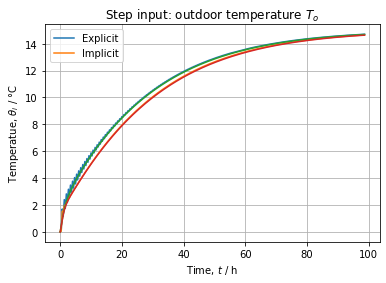

In [2795]:
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()

The previous graph shows the evolution of the temperature according to time. We see that both explicit and implicit methods converge to the same temperature, with seems equal to 15°C. We still observ that the evolution doesn't follow the same path if we chose a method or the other.
We see that the implicit method doesn't present any vibrations at the beginnig of the curves. Also, we know that this method gives a smaller mistake than the explicit method.

In [2796]:
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: pièce 1 : {float(θ[9]):.4f} °C et pièce 2 : {float(θ[16]):.4f} °C ')
print(f'- state-space model: pièce 1 : {float(yss[0]):.4f} °C et pièce 2 : {float(yss[1]):.4f} °C')
print(f'- steady-state response to step input: pièce 1 : {float(y_exp[0, -2]):.4f} °C et pièce 2 : {float(y_exp[1, -2]):.4f} °C')

Steady-state indoor temperature obtained with:
- DAE model: pièce 1 : 15.0000 °C et pièce 2 : 15.0000 °C 
- state-space model: pièce 1 : 15.0000 °C et pièce 2 : 15.0000 °C
- steady-state response to step input: pièce 1 : 14.6988 °C et pièce 2 : 14.6487 °C


# Simulation with weather data

In this part, we will improve our model to take into account eventual weather changes and influences.

2000-01-03 12:00:00 	start date
2000-02-05 18:00:00 	end date
pièce 1:


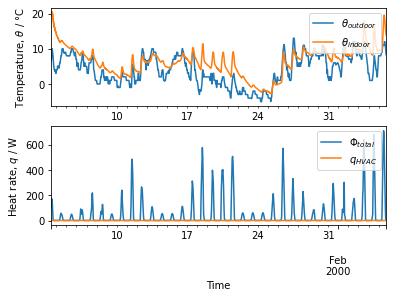

pièce 2:


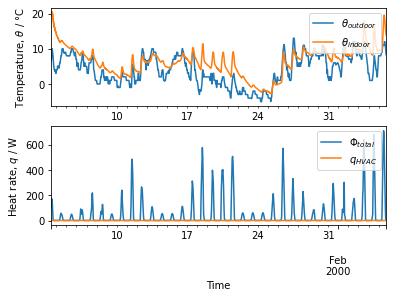

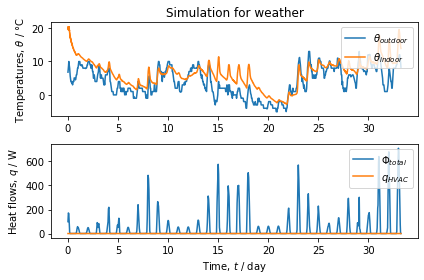

In [2797]:
# weather data 

start_date = '01-03 12:00:00'
end_date = '02-05 18:00:00'
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')
filename = 'FRA_Lyon.074810_IWEC.epw'

[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
# pd.DataFrame(rad_surf)
rad_surf['Φtot'] = rad_surf.sum(axis=1)
# resample weather data
data = pd.concat([weather['temp_air'], rad_surf['Φtot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'Tout'})
# pd.DataFrame(data)
data['Thvac'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
# pd.DataFrame(data)
# input vector
To = data['Tout']
Thvac = data['Thvac']

# radiative properties
ε_wLW = 0.85    # long wave emmisivity: wall surface (concrete)
ε_gLW = 0.90    # long wave emmisivity: glass pyrex
α_wSW = 0.25    # short wave absortivity: white smooth surface
α_gSW = 0.38    # short wave absortivity: reflective blue glass
τ_gSW = 0.30    # short wave transmitance: reflective blue glass


Φo = α_wSW * wall['Surface']['Layer_out'] * data['Φtot']
Φi = τ_gSW * α_wSW * wall['Surface']['Glass'] * data['Φtot']
Qa = data['Qa']
Φa = α_gSW * wall['Surface']['Glass'] * data['Φtot']

u = pd.concat([To, To, To, To, Thvac, To, Thvac,To, Φo, Φi, Φa, Qa, Qa], axis=1)
u.columns.values[[8, 9, 10]] = ['Φo', 'Φi', 'Φa']
# pd.DataFrame(u)

θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k,:]
y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Thvac'] - y_exp[0,:])
data['θi_exp1'] = y_exp.T[:,0]
data['θi_exp2'] = y_exp.T[:,1]

data['q_HVAC'] = q_HVAC.T
# pour la pièce 1
print("pièce 1:")
fig, axs = plt.subplots(2, 1)

data[['Tout', 'θi_exp1']].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Φtot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / W')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
             loc='upper right')
plt.show()
# pour la pièce 2
print("pièce 2:")
fig, axs = plt.subplots(2, 1)

data[['Tout', 'θi_exp1']].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Φtot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / W')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
             loc='upper right')
plt.show()


t = dt * np.arange(data.shape[0])   # time vector

fig, axs = plt.subplots(2, 1)
# plot outdoor and indoor temperature
axs[0].plot(t / 3600 / 24, data['Tout'], label='$θ_{outdoor}$')
axs[0].plot(t / 3600 / 24, y_exp[0,:], label='$θ_{indoor}$')
axs[0].set(ylabel='Temperatures, $θ$ / °C',
           title='Simulation for weather')
axs[0].legend(loc='upper right')

# plot total solar radiation and HVAC heat flow
axs[1].plot(t / 3600 / 24, data['Φtot'], label='$Φ_{total}$')
axs[1].plot(t / 3600 / 24, q_HVAC, label='$q_{HVAC}$')
axs[1].set(xlabel='Time, $t$ / day',
           ylabel='Heat flows, $q$ / W')
axs[1].legend(loc='upper right')

fig.tight_layout()




As we see on the graphs, the temperature evolves a lot according to the weather changes. For a real building, we sill need to set changes to compensate the influence of weather